## First Neural Network

In [1]:
!pip install tsfresh



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.1/169.1 kB 9.3 MB/s eta 0:00:00


In [2]:

!pip install keras-tuner


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.1 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
from tsfresh import extract_features
from tsfresh.feature_extraction import ComprehensiveFCParameters

# If you need to plot or visualize data later on
import matplotlib.pyplot as plt
import seaborn as sns

# For any data preprocessing or manipulation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Depending on the models you plan to use
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


## Dataset

In [5]:
fazeli_mitbih_train_df = pd.read_csv('/content/drive/MyDrive/mitbih_train.csv', header=None)

In [6]:
fazeli_mitbih_test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/mitbih_test.csv', header=None)

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [7]:
column_187 = fazeli_mitbih_train_df.iloc[:, 187]
column_187.value_counts()

0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: 187, dtype: int64

# WIP Neural Network

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout

# Assuming your input shape is (timesteps, features)
input_shape = (187, 1)  # Adjusted input shape to match your dataset

model = Sequential([
    Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=input_shape),
    MaxPooling1D(pool_size=2),
    Dropout(0.1),

    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.1),

    Conv1D(filters=256, kernel_size=3, activation='relu'),
    GlobalAveragePooling1D(),

    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')  # Adjusted for 5 classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 183, 64)           384       
                                                                 
 max_pooling1d (MaxPooling1  (None, 91, 64)            0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 91, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 89, 128)           24704     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 44, 128)           0         
 g1D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 44, 128)           0

In [9]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Assuming fazeli_mitbih_train_df is your DataFrame and the last column is the label
X = fazeli_mitbih_train_df.iloc[:, :-1].values
y = fazeli_mitbih_train_df.iloc[:, -1].values

# Reshape X to fit the Conv1D input requirements and convert y to categorical
X_reshaped = X.reshape((X.shape[0], X.shape[1], 1))
y_categorical = to_categorical(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_categorical, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))


Epoch 1/10
2189/2189 [==============================] - 16s 5ms/step - loss: 0.4301 - accuracy: 0.8802 - val_loss: 0.2590 - val_accuracy: 0.9272
Epoch 2/10
2189/2189 [==============================] - 10s 5ms/step - loss: 0.2541 - accuracy: 0.9300 - val_loss: 0.2095 - val_accuracy: 0.9407
Epoch 3/10
2189/2189 [==============================] - 10s 5ms/step - loss: 0.2117 - accuracy: 0.9406 - val_loss: 0.1713 - val_accuracy: 0.9485
Epoch 4/10
2189/2189 [==============================] - 10s 5ms/step - loss: 0.1876 - accuracy: 0.9476 - val_loss: 0.1489 - val_accuracy: 0.9556
Epoch 5/10
2189/2189 [==============================] - 10s 5ms/step - loss: 0.1692 - accuracy: 0.9517 - val_loss: 0.1395 - val_accuracy: 0.9603
Epoch 6/10
2189/2189 [==============================] - 10s 5ms/step - loss: 0.1561 - accuracy: 0.9564 - val_loss: 0.1250 - val_accuracy: 0.9633
Epoch 7/10
2189/2189 [==============================] - 10s 5ms/step - loss: 0.1436 - accuracy: 0.9600 - val_loss: 0.1104 - val_ac

In [12]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Assuming fazeli_mitbih_train_df is your DataFrame and the last column is the label
X = fazeli_mitbih_train_df.iloc[:, :-1].values
y = fazeli_mitbih_train_df.iloc[:, -1].values

# Reshape X to fit the Conv1D input requirements and convert y to categorical
X_reshaped = X.reshape((X.shape[0], X.shape[1], 1))
y_categorical = to_categorical(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_categorical, test_size=0.2, random_state=42)

# Define the ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(
    'best_model.h5',  # Path where to save the model
    monitor='val_loss',
    save_best_only=True,  # Only save the best model
    verbose=1
)

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.001,
    verbose=1
)

# Train the model with the callbacks
history = model.fit(
    X_train,
    y_train,
    epochs=100,  # Adjust the number of epochs if necessary
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr, model_checkpoint]  # Add ModelCheckpoint to the callbacks list
)


Epoch 1/100
2180/2189 [============================>.] - ETA: 0s - loss: 0.1183 - accuracy: 0.9681
Epoch 1: val_loss improved from inf to 0.09765, saving model to best_model.h5
2189/2189 [==============================] - 10s 5ms/step - loss: 0.1184 - accuracy: 0.9681 - val_loss: 0.0976 - val_accuracy: 0.9736 - lr: 0.0010
Epoch 2/100
  39/2189 [..............................] - ETA: 8s - loss: 0.1191 - accuracy: 0.9696

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2181/2189 [============================>.] - ETA: 0s - loss: 0.1127 - accuracy: 0.9690
Epoch 2: val_loss improved from 0.09765 to 0.09134, saving model to best_model.h5
2189/2189 [==============================] - 10s 5ms/step - loss: 0.1125 - accuracy: 0.9690 - val_loss: 0.0913 - val_accuracy: 0.9742 - lr: 0.0010
Epoch 3/100
2181/2189 [============================>.] - ETA: 0s - loss: 0.1088 - accuracy: 0.9703
Epoch 3: val_loss did not improve from 0.09134
2189/2189 [==============================] - 10s 5ms/step - loss: 0.1087 - accuracy: 0.9704 - val_loss: 0.0951 - val_accuracy: 0.9745 - lr: 0.0010
Epoch 4/100
2189/2189 [==============================] - ETA: 0s - loss: 0.1039 - accuracy: 0.9714
Epoch 4: val_loss improved from 0.09134 to 0.08341, saving model to best_model.h5
2189/2189 [==============================] - 10s 5ms/step - loss: 0.1039 - accuracy: 0.9714 - val_loss: 0.0834 - val_accuracy: 0.9760 - lr: 0.0010
Epoch 5/100
2186/2189 [============================>.] - ETA: 0

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout, BatchNormalization

# Assuming your input shape is (timesteps, features)
input_shape = (187, 1)  # Adjusted input shape to match your dataset

model = Sequential([
    Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=input_shape),
    BatchNormalization(),  # Batch Normalization layer after Convolution
    MaxPooling1D(pool_size=2),
    Dropout(0.1),

    Conv1D(filters=128, kernel_size=3, activation='relu'),
    BatchNormalization(),  # Another Batch Normalization layer
    MaxPooling1D(pool_size=2),
    Dropout(0.1),

    Conv1D(filters=256, kernel_size=3, activation='relu'),
    BatchNormalization(),  # And another one
    GlobalAveragePooling1D(),

    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')  # Adjusted for 5 classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 183, 64)           384       
                                                                 
 batch_normalization (Batch  (None, 183, 64)           256       
 Normalization)                                                  
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 91, 64)            0         
 g1D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 91, 64)            0         
                                                                 
 conv1d_4 (Conv1D)           (None, 89, 128)           24704     
                                                                 
 batch_normalization_1 (Bat  (None, 89, 128)          

In [16]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Assuming fazeli_mitbih_train_df is your DataFrame and the last column is the label
X = fazeli_mitbih_train_df.iloc[:, :-1].values
y = fazeli_mitbih_train_df.iloc[:, -1].values

# Reshape X to fit the Conv1D input requirements and convert y to categorical
X_reshaped = X.reshape((X.shape[0], X.shape[1], 1))
y_categorical = to_categorical(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_categorical, test_size=0.2, random_state=42)

# Define the ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(
    'best_model.h5',  # Path where to save the model
    monitor='val_loss',
    save_best_only=True,  # Only save the best model
    verbose=1
)

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.001,
    verbose=1
)

# Train the model with the callbacks
history = model.fit(
    X_train,
    y_train,
    epochs=100,  # Adjust the number of epochs if necessary
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr, model_checkpoint]  # Add ModelCheckpoint to the callbacks list
)


Epoch 1/100
2183/2189 [============================>.] - ETA: 0s - loss: 0.2579 - accuracy: 0.9287
Epoch 1: val_loss improved from inf to 0.15190, saving model to best_model.h5
2189/2189 [==============================] - 18s 7ms/step - loss: 0.2580 - accuracy: 0.9287 - val_loss: 0.1519 - val_accuracy: 0.9611 - lr: 0.0010
Epoch 2/100
  19/2189 [..............................] - ETA: 13s - loss: 0.1197 - accuracy: 0.9655

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2185/2189 [============================>.] - ETA: 0s - loss: 0.1517 - accuracy: 0.9583
Epoch 2: val_loss did not improve from 0.15190
2189/2189 [==============================] - 14s 6ms/step - loss: 0.1516 - accuracy: 0.9584 - val_loss: 0.1894 - val_accuracy: 0.9445 - lr: 0.0010
Epoch 3/100
2186/2189 [============================>.] - ETA: 0s - loss: 0.1279 - accuracy: 0.9650
Epoch 3: val_loss improved from 0.15190 to 0.10350, saving model to best_model.h5
2189/2189 [==============================] - 15s 7ms/step - loss: 0.1280 - accuracy: 0.9650 - val_loss: 0.1035 - val_accuracy: 0.9707 - lr: 0.0010
Epoch 4/100
2182/2189 [============================>.] - ETA: 0s - loss: 0.1175 - accuracy: 0.9677
Epoch 4: val_loss improved from 0.10350 to 0.09959, saving model to best_model.h5
2189/2189 [==============================] - 15s 7ms/step - loss: 0.1175 - accuracy: 0.9677 - val_loss: 0.0996 - val_accuracy: 0.9750 - lr: 0.0010
Epoch 5/100
2186/2189 [============================>.] - ETA: 0

In [19]:
import numpy as np
from tensorflow.keras.utils import to_categorical

# Assuming the last column is the label
X_test_df = fazeli_mitbih_test_df.iloc[:, :-1].values
y_test_df = fazeli_mitbih_test_df.iloc[:, -1].values

# Reshape X to fit the Conv1D input requirements
X_test_reshaped = X_test_df.reshape((X_test_df.shape[0], X_test_df.shape[1], 1))

# Convert y to categorical if your model's output is categorical
y_test_categorical = to_categorical(y_test_df)

# Evaluate the model on the separate test set
test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test_categorical)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


685/685 [==============================] - 2s 3ms/step - loss: 0.0649 - accuracy: 0.9846
Test Loss: 0.06490693241357803
Test Accuracy: 0.9845605492591858


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras_tuner import HyperModel

class CNNHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = Sequential()
        model.add(Conv1D(
            filters=hp.Int('filters_1', min_value=32, max_value=128, step=32),
            kernel_size=hp.Choice('kernel_size_1', values=[3, 5]),
            activation='relu', input_shape=self.input_shape))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, default=0.25, step=0.05)))

        model.add(Conv1D(
            filters=hp.Int('filters_2', min_value=64, max_value=256, step=32),
            kernel_size=hp.Choice('kernel_size_2', values=[3, 5]),
            activation='relu'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.0, max_value=0.5, default=0.25, step=0.05)))

        model.add(GlobalAveragePooling1D())

        model.add(Dense(
            units=hp.Int('units', min_value=50, max_value=150, step=50),
            activation='relu'))
        model.add(Dropout(rate=hp.Float('dropout_3', min_value=0.0, max_value=0.5, default=0.25, step=0.05)))
        model.add(Dense(5, activation='softmax'))  # Assuming 5 classes

        model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        return model


In [20]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras_tuner import HyperModel, Hyperband
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Assuming fazeli_mitbih_train_df is your DataFrame and the last column is the label
X = fazeli_mitbih_train_df.iloc[:, :-1].values
y = fazeli_mitbih_train_df.iloc[:, -1].values

# Reshape X to fit the Conv1D input requirements and convert y to categorical
X_reshaped = X.reshape((X.shape[0], X.shape[1], 1))
y_categorical = to_categorical(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_categorical, test_size=0.2, random_state=42)

# Define callbacks (assuming they're already defined in your script)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1)

class CNNHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = Sequential()
        model.add(Conv1D(
            filters=hp.Int('filters_1', min_value=32, max_value=128, step=32),
            kernel_size=hp.Choice('kernel_size_1', values=[3, 5]),
            activation='relu', input_shape=self.input_shape))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, default=0.25, step=0.05)))

        model.add(Conv1D(
            filters=hp.Int('filters_2', min_value=64, max_value=256, step=32),
            kernel_size=hp.Choice('kernel_size_2', values=[3, 5]),
            activation='relu'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.0, max_value=0.5, default=0.25, step=0.05)))

        model.add(GlobalAveragePooling1D())

        model.add(Dense(
            units=hp.Int('units', min_value=50, max_value=150, step=50),
            activation='relu'))
        model.add(Dropout(rate=hp.Float('dropout_3', min_value=0.0, max_value=0.5, default=0.25, step=0.05)))
        model.add(Dense(5, activation='softmax'))  # Assuming 5 classes

        model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        return model

# Instantiate and configure the hypermodel
hypermodel = CNNHyperModel(input_shape=(187, 1))

# Instantiate the tuner
tuner = Hyperband(
    hypermodel,
    objective='val_accuracy',
    max_epochs=10,
    directory='hyperband',
    project_name='mitbih_classification'
)

# Start the search for the best hyperparameter configuration
tuner.search(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=10, callbacks=[early_stopping, reduce_lr, model_checkpoint])


Trial 30 Complete [00h 01m 38s]
val_accuracy: 0.9037176370620728

Best val_accuracy So Far: 0.9696761965751648
Total elapsed time: 00h 20m 10s


In [22]:
best_hyperparameters = tuner.get_best_hyperparameters()[0]

# Print each hyperparameter and its value
print("Best Hyperparameters:")
for hp in best_hyperparameters.space:
    print(f"{hp.name}: {best_hyperparameters.get(hp.name)}")


Best Hyperparameters:
filters_1: 128
kernel_size_1: 5
dropout_1: 0.1
filters_2: 128
kernel_size_2: 5
dropout_2: 0.05
units: 150
dropout_3: 0.30000000000000004
learning_rate: 0.0018203143877091666


In [23]:
def create_model_with_best_hyperparameters():
    model = Sequential()
    model.add(Conv1D(
        filters=best_hyperparameters.get('filters_1'),
        kernel_size=best_hyperparameters.get('kernel_size_1'),
        activation='relu', input_shape=(187, 1)))  # Adjust input_shape if necessary
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(rate=best_hyperparameters.get('dropout_1')))

    model.add(Conv1D(
        filters=best_hyperparameters.get('filters_2'),
        kernel_size=best_hyperparameters.get('kernel_size_2'),
        activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(rate=best_hyperparameters.get('dropout_2')))

    model.add(GlobalAveragePooling1D())

    model.add(Dense(
        units=best_hyperparameters.get('units'),
        activation='relu'))
    model.add(Dropout(rate=best_hyperparameters.get('dropout_3')))
    model.add(Dense(5, activation='softmax'))  # Adjust the number of classes if necessary

    model.compile(optimizer=Adam(best_hyperparameters.get('learning_rate')),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Create model with the best hyperparameters
model = create_model_with_best_hyperparameters()


In [7]:
best_hyperparameters = {
    'filters_1': 128,
    'kernel_size_1': 5,
    'dropout_1': 0.1,
    'filters_2': 128,
    'kernel_size_2': 5,
    'dropout_2': 0.05,
    'units': 150,
    'dropout_3': 0.3,
    'learning_rate': 0.0018203143877091666
}


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def create_model_with_best_hyperparameters(hp):
    model = Sequential([
        Conv1D(
            filters=hp['filters_1'],
            kernel_size=hp['kernel_size_1'],
            activation='relu', input_shape=(187, 1)),  # Adjust input_shape if necessary
        MaxPooling1D(pool_size=2),
        Dropout(rate=hp['dropout_1']),

        Conv1D(
            filters=hp['filters_2'],
            kernel_size=hp['kernel_size_2'],
            activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(rate=hp['dropout_2']),

        GlobalAveragePooling1D(),

        Dense(
            units=hp['units'],
            activation='relu'),
        Dropout(rate=hp['dropout_3']),
        Dense(5, activation='softmax')  # Adjust the number of classes if necessary
    ])

    model.compile(optimizer=Adam(learning_rate=hp['learning_rate']),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Create the model with the best hyperparameters
model_with_best_hyperparameters = create_model_with_best_hyperparameters(best_hyperparameters)


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

def create_model_with_best_hyperparameters():
    input_shape = (187, 1)  # Assuming this is your input shape based on the dataset
    model = Sequential([
        Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.1),

        Conv1D(filters=128, kernel_size=5, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.05),

        GlobalAveragePooling1D(),

        Dense(150, activation='relu'),
        Dropout(0.3),
        Dense(5, activation='softmax')  # Adjusted for 5 classes
    ])

    model.compile(optimizer=Adam(learning_rate=0.0018203143877091666), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Create the model with the best hyperparameters
model_with_best_hyperparameters = create_model_with_best_hyperparameters()


Epoch 1/100
2182/2189 [============================>.] - ETA: 0s - loss: 0.2317 - accuracy: 0.9336
Epoch 1: val_loss improved from inf to 0.20866, saving model to best_model_with_hyperparameters.h5
2189/2189 [==============================] - 17s 6ms/step - loss: 0.2314 - accuracy: 0.9337 - val_loss: 0.2087 - val_accuracy: 0.9398 - lr: 0.0018
Epoch 2/100
  19/2189 [..............................] - ETA: 12s - loss: 0.1397 - accuracy: 0.9572

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2186/2189 [============================>.] - ETA: 0s - loss: 0.1496 - accuracy: 0.9575
Epoch 2: val_loss improved from 0.20866 to 0.11767, saving model to best_model_with_hyperparameters.h5
2189/2189 [==============================] - 14s 6ms/step - loss: 0.1496 - accuracy: 0.9575 - val_loss: 0.1177 - val_accuracy: 0.9663 - lr: 0.0018
Epoch 3/100
2181/2189 [============================>.] - ETA: 0s - loss: 0.1323 - accuracy: 0.9630
Epoch 3: val_loss improved from 0.11767 to 0.11243, saving model to best_model_with_hyperparameters.h5
2189/2189 [==============================] - 14s 6ms/step - loss: 0.1323 - accuracy: 0.9630 - val_loss: 0.1124 - val_accuracy: 0.9670 - lr: 0.0018
Epoch 4/100
2189/2189 [==============================] - ETA: 0s - loss: 0.1194 - accuracy: 0.9665
Epoch 4: val_loss did not improve from 0.11243
2189/2189 [==============================] - 13s 6ms/step - loss: 0.1194 - accuracy: 0.9665 - val_loss: 0.1299 - val_accuracy: 0.9619 - lr: 0.0018
Epoch 5/100
2185/2189

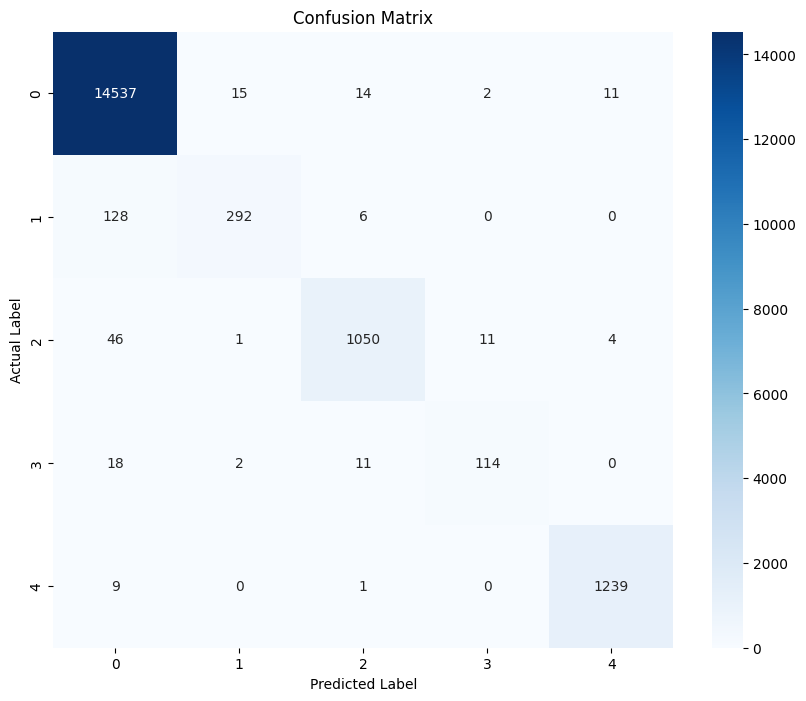

In [11]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model  # Assuming you might want to load the best model

# Assuming fazeli_mitbih_train_df is your DataFrame and the last column is the label
X = fazeli_mitbih_train_df.iloc[:, :-1].values
y = fazeli_mitbih_train_df.iloc[:, -1].values

# Reshape X to fit the Conv1D input requirements and convert y to categorical
X_reshaped = X.reshape((X.shape[0], X.shape[1], 1))
y_categorical = to_categorical(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_categorical, test_size=0.2, random_state=42)

# Define the ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(
    'best_model_with_hyperparameters.h5',  # Update the filename to reflect it's the model with best hyperparameters
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.001,
    verbose=1
)

# Assuming you have the best hyperparameters already, create the model with them
model_with_best_hyperparameters

# Train the model with the callbacks
history_with_best_hyperparameters = model_with_best_hyperparameters.fit(
    X_train,
    y_train,
    epochs=100,  # Adjust the number of epochs if necessary
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

# Optionally, load the best model saved during training
# best_model = load_model('best_model_with_hyperparameters.h5')

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions
y_pred = model_with_best_hyperparameters.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Evaluation on Test Data
test_loss, test_accuracy = model_with_best_hyperparameters.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.title("Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()



Now experimenting with LSTM

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def create_model_LSTM():
    input_shape = (187, 1)  # Assuming this is your input shape based on the dataset
    model = Sequential([
        LSTM(units=128, input_shape=input_shape, return_sequences=True),
        Dropout(0.1),

        LSTM(units=64, return_sequences=False),
        Dropout(0.1),

        Dense(units=150, activation='relu'),
        Dropout(0.3),
        Dense(5, activation='softmax')  # Adjusted for 5 classes
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Create the LSTM model
model_LSTM = create_model_LSTM()

# Now you can use model_LSTM for training just like you did with model_with_best_hyperparameters


In [10]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model  # If you wish to load the best model later

# Assuming fazeli_mitbih_train_df is your DataFrame and the last column is the label
X = fazeli_mitbih_train_df.iloc[:, :-1].values
y = fazeli_mitbih_train_df.iloc[:, -1].values

# Reshape X to fit the LSTM input requirements and convert y to categorical
X_reshaped = X.reshape((X.shape[0], X.shape[1], 1))
y_categorical = to_categorical(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_categorical, test_size=0.2, random_state=42)

# Define callbacks
model_checkpoint = ModelCheckpoint(
    'best_model_LSTM.h5',  # Update the filename to reflect this is the LSTM model
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.001,
    verbose=1
)

# Create the LSTM model with the best hyperparameters
# Assuming 'create_model_LSTM()' function is defined and returns the LSTM model
model_LSTM = create_model_LSTM()

# Train the LSTM model with the callbacks
history_LSTM = model_LSTM.fit(
    X_train,
    y_train,
    epochs=100,  # Adjust the number of epochs as necessary
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

# Optionally, load the best model saved during training
# best_model_LSTM = load_model('best_model_LSTM.h5')

# Evaluation on Test Data
test_loss, test_accuracy = model_LSTM.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Predictions and Classification Report
y_pred = model_LSTM.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred_classes))


Epoch 1/100
2189/2189 [==============================] - ETA: 0s - loss: 0.6737 - accuracy: 0.8264
Epoch 1: val_loss improved from inf to 0.63237, saving model to best_model_LSTM.h5
2189/2189 [==============================] - 40s 16ms/step - loss: 0.6737 - accuracy: 0.8264 - val_loss: 0.6324 - val_accuracy: 0.8315 - lr: 0.0010
Epoch 2/100
   9/2189 [..............................] - ETA: 30s - loss: 0.6807 - accuracy: 0.8264

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2189/2189 [==============================] - ETA: 0s - loss: 0.6088 - accuracy: 0.8256
Epoch 2: val_loss improved from 0.63237 to 0.52314, saving model to best_model_LSTM.h5
2189/2189 [==============================] - 34s 16ms/step - loss: 0.6088 - accuracy: 0.8256 - val_loss: 0.5231 - val_accuracy: 0.8480 - lr: 0.0010
Epoch 3/100
2188/2189 [============================>.] - ETA: 0s - loss: 0.4233 - accuracy: 0.8837
Epoch 3: val_loss improved from 0.52314 to 0.35900, saving model to best_model_LSTM.h5
2189/2189 [==============================] - 34s 16ms/step - loss: 0.4231 - accuracy: 0.8837 - val_loss: 0.3590 - val_accuracy: 0.9077 - lr: 0.0010
Epoch 4/100
2189/2189 [==============================] - ETA: 0s - loss: 0.3893 - accuracy: 0.8915
Epoch 4: val_loss improved from 0.35900 to 0.32623, saving model to best_model_LSTM.h5
2189/2189 [==============================] - 34s 16ms/step - loss: 0.3893 - accuracy: 0.8915 - val_loss: 0.3262 - val_accuracy: 0.9111 - lr: 0.0010
Epoch 5/10

NameError: name 'confusion_matrix' is not defined

Trying bidirectionality


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def create_model_LSTM_bidirectional():
    input_shape = (187, 1)  # Assuming this is your input shape based on the dataset
    model = Sequential([
        # Wrapping the LSTM layer with Bidirectional
        Bidirectional(LSTM(units=128, return_sequences=True), input_shape=input_shape),
        Dropout(0.1),

        # Adding another Bidirectional LSTM layer
        Bidirectional(LSTM(units=64, return_sequences=False)),
        Dropout(0.1),

        # Dense layer as before
        Dense(units=150, activation='relu'),
        Dropout(0.3),
        Dense(5, activation='softmax')  # Adjusted for 5 classes
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Create the bidirectional LSTM model
model_LSTM_bidirectional = create_model_LSTM_bidirectional()

# Now you can use model_LSTM_bidirectional for training just like you did with the original model


In [9]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
# No need to load the best model immediately after training since we're using callbacks to manage this

# Assuming fazeli_mitbih_train_df is your DataFrame and the last column is the label
X = fazeli_mitbih_train_df.iloc[:, :-1].values
y = fazeli_mitbih_train_df.iloc[:, -1].values

# Reshape X to fit the LSTM input requirements and convert y to categorical
X_reshaped = X.reshape((X.shape[0], X.shape[1], 1))
y_categorical = to_categorical(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_categorical, test_size=0.2, random_state=42)

# Define callbacks
model_checkpoint = ModelCheckpoint(
    'best_model_LSTM_bidirectional.h5',  # Updated filename to reflect it's the bidirectional LSTM model
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.001,
    verbose=1
)

# Create the bidirectional LSTM model with the best hyperparameters
# Assuming 'create_model_LSTM_bidirectional()' function is defined and returns the bidirectional LSTM model
model_LSTM_bidirectional = create_model_LSTM_bidirectional()

# Train the bidirectional LSTM model with the callbacks
history_LSTM_bidirectional = model_LSTM_bidirectional.fit(
    X_train,
    y_train,
    epochs=100,  # Adjust the number of epochs as necessary
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

# Optionally, load the best model saved during training
# best_model_LSTM_bidirectional = load_model('best_model_LSTM_bidirectional.h5')

# Evaluation on Test Data
test_loss, test_accuracy = model_LSTM_bidirectional.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Predictions and Classification Report
y_pred = model_LSTM_bidirectional.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred_classes))


Epoch 1/100
2189/2189 [==============================] - ETA: 0s - loss: 0.3221 - accuracy: 0.9170
Epoch 1: val_loss improved from inf to 0.17689, saving model to best_model_LSTM_bidirectional.h5
2189/2189 [==============================] - 80s 33ms/step - loss: 0.3221 - accuracy: 0.9170 - val_loss: 0.1769 - val_accuracy: 0.9508 - lr: 0.0010
Epoch 2/100
   5/2189 [..............................] - ETA: 1:00 - loss: 0.1799 - accuracy: 0.9563

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2189/2189 [==============================] - ETA: 0s - loss: 0.1750 - accuracy: 0.9525
Epoch 2: val_loss improved from 0.17689 to 0.15195, saving model to best_model_LSTM_bidirectional.h5
2189/2189 [==============================] - 68s 31ms/step - loss: 0.1750 - accuracy: 0.9525 - val_loss: 0.1519 - val_accuracy: 0.9587 - lr: 0.0010
Epoch 3/100
2189/2189 [==============================] - ETA: 0s - loss: 0.1398 - accuracy: 0.9618
Epoch 3: val_loss improved from 0.15195 to 0.11292, saving model to best_model_LSTM_bidirectional.h5
2189/2189 [==============================] - 68s 31ms/step - loss: 0.1398 - accuracy: 0.9618 - val_loss: 0.1129 - val_accuracy: 0.9660 - lr: 0.0010
Epoch 4/100
2189/2189 [==============================] - ETA: 0s - loss: 0.1225 - accuracy: 0.9663
Epoch 4: val_loss improved from 0.11292 to 0.10153, saving model to best_model_LSTM_bidirectional.h5
2189/2189 [==============================] - 68s 31ms/step - loss: 0.1225 - accuracy: 0.9663 - val_loss: 0.1015 - va

NameError: name 'confusion_matrix' is not defined

bidirectionality with another layer

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

def create_model_LSTM_bidirectional_2():
    input_shape = (187, 1)  # Assuming this is your input shape based on the dataset
    model = Sequential([
        Bidirectional(LSTM(units=128, return_sequences=True), input_shape=input_shape),
        Dropout(0.1),

        Bidirectional(LSTM(units=64, return_sequences=True)),
        Dropout(0.1),

        Bidirectional(LSTM(units=32, return_sequences=False)),  # Additional layer
        Dropout(0.1),

        Dense(units=150, activation='relu'),
        Dropout(0.3),
        Dense(5, activation='softmax')  # Adjusted for 5 classes
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Create the LSTM model with two bidirectional layers
model_LSTM_bidirectional_2 = create_model_LSTM_bidirectional_2()


In [11]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model

# Assuming fazeli_mitbih_train_df is your DataFrame and the last column is the label
X = fazeli_mitbih_train_df.iloc[:, :-1].values
y = fazeli_mitbih_train_df.iloc[:, -1].values

# Reshape X to fit the LSTM input requirements and convert y to categorical
X_reshaped = X.reshape((X.shape[0], X.shape[1], 1))
y_categorical = to_categorical(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_categorical, test_size=0.2, random_state=42)

# Define callbacks
model_checkpoint = ModelCheckpoint(
    'best_model_LSTM_bidirectional_2.h5',  # Updated filename for the new bidirectional model
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.001,
    verbose=1
)

# Assuming 'create_model_LSTM_bidirectional_2()' function is defined and returns the bidirectional LSTM model
model_LSTM_bidirectional_2 = create_model_LSTM_bidirectional_2()

# Train the bidirectional LSTM model with the callbacks
history_LSTM_bidirectional_2 = model_LSTM_bidirectional_2.fit(
    X_train,
    y_train,
    epochs=100,  # Adjust the number of epochs as necessary
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

# Optionally, load the best model saved during training
# best_model_LSTM_bidirectional_2 = load_model('best_model_LSTM_bidirectional_2.h5')

# Evaluation on Test Data
test_loss, test_accuracy = model_LSTM_bidirectional_2.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Predictions and Classification Report
y_pred = model_LSTM_bidirectional_2.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred_classes))


Epoch 1/100
2189/2189 [==============================] - ETA: 0s - loss: 0.4754 - accuracy: 0.8748
Epoch 1: val_loss improved from inf to 0.24721, saving model to best_model_LSTM_bidirectional_2.h5
2189/2189 [==============================] - 103s 43ms/step - loss: 0.4754 - accuracy: 0.8748 - val_loss: 0.2472 - val_accuracy: 0.9373 - lr: 0.0010
Epoch 2/100
   3/2189 [..............................] - ETA: 1:21 - loss: 0.2075 - accuracy: 0.9479

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2189/2189 [==============================] - ETA: 0s - loss: 0.2653 - accuracy: 0.9314
Epoch 2: val_loss did not improve from 0.24721
2189/2189 [==============================] - 90s 41ms/step - loss: 0.2653 - accuracy: 0.9314 - val_loss: 0.3246 - val_accuracy: 0.9130 - lr: 0.0010
Epoch 3/100
2189/2189 [==============================] - ETA: 0s - loss: 0.1852 - accuracy: 0.9490
Epoch 3: val_loss improved from 0.24721 to 0.13139, saving model to best_model_LSTM_bidirectional_2.h5
2189/2189 [==============================] - 90s 41ms/step - loss: 0.1852 - accuracy: 0.9490 - val_loss: 0.1314 - val_accuracy: 0.9620 - lr: 0.0010
Epoch 4/100
2189/2189 [==============================] - ETA: 0s - loss: 0.1505 - accuracy: 0.9572
Epoch 4: val_loss improved from 0.13139 to 0.11245, saving model to best_model_LSTM_bidirectional_2.h5
2189/2189 [==============================] - 89s 41ms/step - loss: 0.1505 - accuracy: 0.9572 - val_loss: 0.1125 - val_accuracy: 0.9684 - lr: 0.0010
Epoch 5/100
2189/2

Hyperparamater Tuning a 2 layer Bidirectional LSTM model

In [12]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras_tuner import HyperModel, Hyperband
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

class LSTMHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        model = Sequential()
        model.add(Bidirectional(LSTM(units=hp.Int('units_1', min_value=32, max_value=128, step=32), return_sequences=True), input_shape=self.input_shape))
        model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, default=0.25, step=0.1)))

        # Adding another bidirectional LSTM layer if return_sequences is set to True
        model.add(Bidirectional(LSTM(units=hp.Int('units_2', min_value=64, max_value=256, step=32), return_sequences=False)))
        model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.0, max_value=0.5, default=0.25, step=0.1)))

        model.add(Dense(units=hp.Int('dense_units', min_value=50, max_value=150, step=50), activation='relu'))
        model.add(Dropout(rate=hp.Float('dropout_3', min_value=0.0, max_value=0.5, default=0.25, step=0.1)))

        model.add(Dense(self.num_classes, activation='softmax'))

        model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        return model

# Load your data
X = fazeli_mitbih_train_df.iloc[:, :-1].values
y = fazeli_mitbih_train_df.iloc[:, -1].values

# Preprocess the data
X_reshaped = X.reshape((X.shape[0], X.shape[1], 1))
y_categorical = to_categorical(y)
num_classes = y_categorical.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_categorical, test_size=0.2, random_state=42)

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1),
    ModelCheckpoint('best_model_LSTM_bidirectional_2.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

# Instantiate and configure the hypermodel
hypermodel = LSTMHyperModel(input_shape=(187, 1), num_classes=num_classes)

# Instantiate the tuner
tuner = Hyperband(
    hypermodel,
    objective='val_accuracy',
    max_epochs=10,
    directory='hyperband',
    project_name='mitbih_lstm_classification'
)

# Start the search for the best hyperparameter configuration
tuner.search(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=10, callbacks=callbacks)


Trial 30 Complete [00h 10m 53s]
val_accuracy: 0.9740163087844849

Best val_accuracy So Far: 0.9820113182067871
Total elapsed time: 02h 18m 46s


In [17]:
# Recreate the tuner with the same configuration
tuner = Hyperband(
    hypermodel,
    objective='val_accuracy',
    max_epochs=10,
    directory='hyperband',  # Same directory as before
    project_name='mitbih_lstm_classification'  # Same project name as before
)

# Load the best hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]

# Print the best hyperparameters
print("Best Hyperparameters:")
for hp in best_hps.space:
    print(f"{hp.name}: {best_hps.get(hp.name)}")


Reloading Tuner from hyperband/mitbih_lstm_classification/tuner0.json
Best Hyperparameters:
units_1: 64
dropout_1: 0.0
units_2: 160
dropout_2: 0.4
dense_units: 100
dropout_3: 0.2
learning_rate: 0.002097863337902064


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

def create_model_LSTM_bidirectional_2_with_best_hps():
    input_shape = (187, 1)  # Assuming this is your input shape based on the dataset
    model = Sequential([
        Bidirectional(LSTM(units=64, return_sequences=True), input_shape=input_shape),  # units_1: 64
        Dropout(0.0),  # dropout_1: 0.0

        Bidirectional(LSTM(units=160, return_sequences=False)),  # units_2: 160
        Dropout(0.4),  # dropout_2: 0.4

        Dense(units=100, activation='relu'),  # dense_units: 100
        Dropout(0.2),  # dropout_3: 0.2

        Dense(5, activation='softmax')  # Assuming 5 classes
    ])

    # learning_rate: 0.002097863337902064
    model.compile(optimizer=Adam(learning_rate=0.002097863337902064), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Create the LSTM model with best hyperparameters
model_LSTM_bidirectional_2_with_best_hps = create_model_LSTM_bidirectional_2_with_best_hps()


In [9]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model

# Assuming fazeli_mitbih_train_df is your DataFrame and the last column is the label
X = fazeli_mitbih_train_df.iloc[:, :-1].values
y = fazeli_mitbih_train_df.iloc[:, -1].values

# Reshape X to fit the LSTM input requirements and convert y to categorical
X_reshaped = X.reshape((X.shape[0], X.shape[1], 1))
y_categorical = to_categorical(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_categorical, test_size=0.2, random_state=42)

# Define callbacks
model_checkpoint = ModelCheckpoint(
    'best_model_LSTM_bidirectional_2_with_best_hps.h5',  # Updated filename for the model with best hyperparameters
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.001,
    verbose=1
)

# Use the model with best hyperparameters you created earlier
model = model_LSTM_bidirectional_2_with_best_hps  # Assuming this model is already created with the function call

# Train the model with the callbacks
history = model.fit(
    X_train,
    y_train,
    epochs=100,  # Adjust the number of epochs as necessary
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

# Evaluation on Test Data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Predictions and Classification Report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

# Confusion Matrix
# (Add confusion matrix visualization code here if needed)


Epoch 1/100
2189/2189 [==============================] - ETA: 0s - loss: 0.3303 - accuracy: 0.9148
Epoch 1: val_loss improved from inf to 0.19216, saving model to best_model_LSTM_bidirectional_2_with_best_hps.h5
2189/2189 [==============================] - 76s 31ms/step - loss: 0.3303 - accuracy: 0.9148 - val_loss: 0.1922 - val_accuracy: 0.9460 - lr: 0.0021
Epoch 2/100
   5/2189 [..............................] - ETA: 1:00 - loss: 0.1781 - accuracy: 0.9563

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2189/2189 [==============================] - ETA: 0s - loss: 0.1739 - accuracy: 0.9529
Epoch 2: val_loss improved from 0.19216 to 0.12433, saving model to best_model_LSTM_bidirectional_2_with_best_hps.h5
2189/2189 [==============================] - 65s 30ms/step - loss: 0.1739 - accuracy: 0.9529 - val_loss: 0.1243 - val_accuracy: 0.9640 - lr: 0.0021
Epoch 3/100
2189/2189 [==============================] - ETA: 0s - loss: 0.1412 - accuracy: 0.9607
Epoch 3: val_loss improved from 0.12433 to 0.11655, saving model to best_model_LSTM_bidirectional_2_with_best_hps.h5
2189/2189 [==============================] - 66s 30ms/step - loss: 0.1412 - accuracy: 0.9607 - val_loss: 0.1166 - val_accuracy: 0.9648 - lr: 0.0021
Epoch 4/100
2189/2189 [==============================] - ETA: 0s - loss: 0.1214 - accuracy: 0.9653
Epoch 4: val_loss improved from 0.11655 to 0.09571, saving model to best_model_LSTM_bidirectional_2_with_best_hps.h5
2189/2189 [==============================] - 68s 31ms/step - loss: 0

Hyperparamater Tuning a 3 layer Bidirectional LSTM model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from keras_tuner import HyperModel, Hyperband
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

class LSTMHyperModel3Layers(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        model = Sequential()
        model.add(Bidirectional(LSTM(units=hp.Int('units_1', min_value=32, max_value=128, step=32), return_sequences=True), input_shape=self.input_shape))
        model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, default=0.25, step=0.1)))
        model.add(Bidirectional(LSTM(units=hp.Int('units_2', min_value=64, max_value=256, step=32), return_sequences=True)))
        model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.0, max_value=0.5, default=0.25, step=0.1)))
        # Additional bidirectional LSTM layer
        model.add(Bidirectional(LSTM(units=hp.Int('units_3', min_value=32, max_value=128, step=32), return_sequences=False)))
        model.add(Dropout(rate=hp.Float('dropout_3', min_value=0.0, max_value=0.5, default=0.25, step=0.1)))
        model.add(Dense(units=hp.Int('dense_units', min_value=50, max_value=150, step=50), activation='relu'))
        model.add(Dropout(rate=hp.Float('dropout_4', min_value=0.0, max_value=0.5, default=0.25, step=0.1)))
        model.add(Dense(self.num_classes, activation='softmax'))
        model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                      loss='categorical_crossentropy', metrics=['accuracy'])
        return model

# Assuming you have your data loaded in X and y
X_reshaped = X.reshape((X.shape[0], X.shape[1], 1))
y_categorical = to_categorical(y)
num_classes = y_categorical.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_categorical, test_size=0.2, random_state=42)

# Instantiate and configure the hypermodel for 3 layers
hypermodel3Layers = LSTMHyperModel3Layers(input_shape=(187, 1), num_classes=num_classes)

# Instantiate the tuner
tuner3Layers = Hyperband(
    hypermodel3Layers,
    objective='val_accuracy',
    max_epochs=10,
    directory='hyperband_3layers',
    project_name='mitbih_lstm_classification_3layers'
)

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1),
    ModelCheckpoint('best_model_LSTM_bidirectional_3layers.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

# Start the search for the best hyperparameter configuration
tuner3Layers.search(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=10, callbacks=callbacks)


Trial 26 Complete [00h 10m 07s]
val_accuracy: 0.9769858717918396

Best val_accuracy So Far: 0.9832676649093628
Total elapsed time: 02h 12m 59s

Search: Running Trial #27

Value             |Best Value So Far |Hyperparameter
96                |64                |units_1
0                 |0                 |dropout_1
64                |160               |units_2
0.4               |0.2               |dropout_2
32                |96                |units_3
0.2               |0.3               |dropout_3
100               |150               |dense_units
0.2               |0.1               |dropout_4
0.00033123        |0.00083801        |learning_rate
10                |10                |tuner/epochs
0                 |4                 |tuner/initial_epoch
0                 |1                 |tuner/bracket
0                 |1                 |tuner/round

Epoch 1/10
2049/2189 [===========================>..] - ETA: 5s - loss: 0.6609 - accuracy: 0.8257

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from keras_tuner import HyperModel, Hyperband
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

class LSTMHyperModel3Layers(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        model = Sequential()
        model.add(Bidirectional(LSTM(units=hp.Int('units_1', min_value=32, max_value=128, step=32), return_sequences=True), input_shape=self.input_shape))
        model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, default=0.25, step=0.1)))
        model.add(Bidirectional(LSTM(units=hp.Int('units_2', min_value=64, max_value=256, step=32), return_sequences=True)))
        model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.0, max_value=0.5, default=0.25, step=0.1)))
        # Additional bidirectional LSTM layer
        model.add(Bidirectional(LSTM(units=hp.Int('units_3', min_value=32, max_value=128, step=32), return_sequences=False)))
        model.add(Dropout(rate=hp.Float('dropout_3', min_value=0.0, max_value=0.5, default=0.25, step=0.1)))
        model.add(Dense(units=hp.Int('dense_units', min_value=50, max_value=150, step=50), activation='relu'))
        model.add(Dropout(rate=hp.Float('dropout_4', min_value=0.0, max_value=0.5, default=0.25, step=0.1)))
        model.add(Dense(self.num_classes, activation='softmax'))
        model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                      loss='categorical_crossentropy', metrics=['accuracy'])
        return model


In [8]:
# Instantiate the tuner
tuner3Layers = Hyperband(
    hypermodel3Layers,
    objective='val_accuracy',
    max_epochs=10,
    directory='hyperband_3layers',
    project_name='mitbih_lstm_classification_3layers'
)


NameError: name 'hypermodel3Layers' is not defined

Training the 3-layer model

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

def create_model_LSTM_3layer_with_best_hps():
    input_shape = (187, 1)  # Assuming this is your input shape based on the dataset
    model = Sequential([
        Bidirectional(LSTM(units=64, return_sequences=True), input_shape=input_shape),  # units_1: 64, using return_sequences=True for stacking
        Dropout(0.0),  # dropout_1: 0.0

        Bidirectional(LSTM(units=160, return_sequences=True)),  # units_2: 160, adapted to return_sequences=True for the next bidirectional layer
        Dropout(0.4),  # dropout_2: 0.4

        Bidirectional(LSTM(units=96, return_sequences=False)),  # units_3: 96, final LSTM layer does not return sequences
        Dropout(0.2),  # dropout_3: 0.2

        Dense(units=150, activation='relu'),  # dense_units: 150
        Dropout(0.1),  # dropout_4: 0.1

        Dense(5, activation='softmax')  # Assuming 5 classes
    ])

    # learning_rate: 0.00083801
    model.compile(optimizer=Adam(learning_rate=0.00083801), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Create the LSTM model with best hyperparameters
model_LSTM_3layer_with_best_hps = create_model_LSTM_3layer_with_best_hps()


In [ ]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming fazeli_mitbih_train_df is your DataFrame and the last column is the label
X = fazeli_mitbih_train_df.iloc[:, :-1].values
y = fazeli_mitbih_train_df.iloc[:, -1].values

# Reshape X to fit the LSTM input requirements and convert y to categorical
X_reshaped = X.reshape((X.shape[0], X.shape[1], 1))
y_categorical = to_categorical(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_categorical, test_size=0.2, random_state=42)

def create_model_LSTM_3layer_with_best_hps():
    input_shape = (187, 1)  # Assuming this is your input shape based on the dataset
    model = Sequential([
        Bidirectional(LSTM(units=64, return_sequences=True), input_shape=input_shape),
        Dropout(0.0),
        Bidirectional(LSTM(units=160, return_sequences=True)),
        Dropout(0.4),
        Bidirectional(LSTM(units=96)),
        Dropout(0.2),
        Dense(units=150, activation='relu'),
        Dropout(0.1),
        Dense(5, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.00083801), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model_LSTM_3layer_with_best_hps = create_model_LSTM_3layer_with_best_hps()

# Define callbacks
model_checkpoint = ModelCheckpoint('best_model_LSTM_3layer_with_best_hps.h5', monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1)

# Train the model with the callbacks
history = model_LSTM_3layer_with_best_hps.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr, model_checkpoint])

# Evaluation on Test Data
test_loss, test_accuracy = model_LSTM_3layer_with_best_hps.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}\nTest Accuracy: {test_accuracy}")

# Predictions and Classification Report
y_pred = model_LSTM_3layer_with_best_hps.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))




Epoch 1/100
2189/2189 [==============================] - ETA: 0s - loss: 0.2993 - accuracy: 0.9208
Epoch 1: val_loss improved from inf to 0.18048, saving model to best_model_LSTM_3layer_with_best_hps.h5
2189/2189 [==============================] - 112s 46ms/step - loss: 0.2993 - accuracy: 0.9208 - val_loss: 0.1805 - val_accuracy: 0.9486 - lr: 8.3801e-04
Epoch 2/100
   3/2189 [..............................] - ETA: 1:26 - loss: 0.1300 - accuracy: 0.9688

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2189/2189 [==============================] - ETA: 0s - loss: 0.1707 - accuracy: 0.9529
Epoch 2: val_loss improved from 0.18048 to 0.13541, saving model to best_model_LSTM_3layer_with_best_hps.h5
2189/2189 [==============================] - 98s 45ms/step - loss: 0.1707 - accuracy: 0.9529 - val_loss: 0.1354 - val_accuracy: 0.9596 - lr: 8.3801e-04
Epoch 3/100
2189/2189 [==============================] - ETA: 0s - loss: 0.1375 - accuracy: 0.9613

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['N', 'S', 'V', 'F', 'Q'], yticklabels=['N', 'S', 'V', 'F', 'Q'])
plt.title("Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()